In [1]:
import numpy as np
import torch as th
from matplotlib import pyplot as plt
from time import time as get_time
from AIGLE import AIGLE
from AIGLE.interpolation import interpolated_fes_2d
from AIGLE import Trajectory
from AIGLE.trainer import Trainer
from AIGLE.utilities import *

np.set_printoptions(precision=8)
dev = 'cuda' if th.cuda.is_available() else 'cpu'


## Load FES and create force engines

In [2]:
kbT2kjmol = 2.479
free_energy = np.load('./metadynamics/biases/free_energy.npy') #kJ/mol
free_energy -= free_energy.min()
free_energy /= kbT2kjmol  # in unit of kbT
free_energy = free_energy.T
nbins = [free_energy.shape[0], free_energy.shape[1]]
x0, y0 = -np.pi, -np.pi       ## origin of the free energy surface table
dx = 2*np.pi / (nbins[0]-1)   ## grid size (x-direction)
dy = 2*np.pi / (nbins[1]-1)   ## grid size (y-direction)
interp_fes = interpolated_fes_2d(free_energy, x0,y0,dx,dy, pbc=True, use_torch=True)


## Load trajectories of coarse-grained variables (Dihedral angles)

In [3]:
kbT = 1
dt = 0.004 # ps
throw = int(40 * 1000 / dt)  ## throw the first 40ns for equilibration
data = np.load('./md_unbiased/cv_traj_100ns_DT4fs.npy')[throw:]
ndim = data.shape[-1]
traj = Trajectory(data, dt=dt, kbT=kbT)
traj.set_calculator(interp_fes)
traj.process_kinetics(transform=True)

## Training GLE

In [4]:
taus = np.array([0.1, 1, 2, 10, 50])
aigle = AIGLE(ndim=ndim, kbT=kbT, ntau=taus.size, nfreq=4, taus=taus ).to(device=dev)
trainer = Trainer(aigle)
trainer.set_traj(traj)
trainer.train(fit_time=100, niter=10000, lr_coef=0.4, lr_tau=0.01, print_freq=100, save_dir='gle_paras')

iter=0, loss=0.009683, tau=[ 0.10000047  1.000048    2.0001938  10.004624   50.075302  ]
iter=100, loss=0.000547, tau=[ 0.10014671  0.99952394  1.9643592   8.36517    43.90009   ]
iter=200, loss=0.000492, tau=[ 0.15903     0.83828175  2.0580246   8.212185   43.86707   ]
iter=300, loss=0.000402, tau=[ 0.19847202  0.61506253  2.0980575   8.206841   43.839874  ]
iter=400, loss=0.000330, tau=[ 0.16945404  0.4517807   2.092654    8.221863   43.80523   ]
iter=500, loss=0.000270, tau=[ 0.14452454  0.3218296   2.0501587   8.240992   43.75381   ]
iter=600, loss=0.000220, tau=[ 0.12814943  0.250968    2.0090342   8.260332   43.58793   ]
iter=700, loss=0.000186, tau=[ 0.1159198   0.21938477  1.9944096   8.303992   43.42551   ]
iter=800, loss=0.000159, tau=[ 0.10540639  0.20526548  1.9939255   8.368981   43.216423  ]
iter=900, loss=0.000147, tau=[ 0.09749804  0.19535887  1.9997436   8.463027   43.031574  ]
iter=1000, loss=0.000125, tau=[ 0.09209796  0.1860642   2.0061743   8.579386   42.79577   ]


## Validate GLE

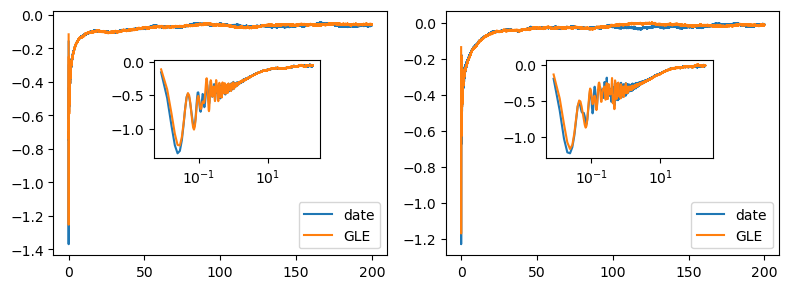

In [5]:
val_time= 200
nmax = int(val_time/dt)
impulse_mem, pred_impulse_mem = trainer.validate(val_time=val_time)
impulse_mem = th2np(impulse_mem)
pred_impulse_mem = th2np(pred_impulse_mem)
##
tgrid = np.arange(1, nmax+1) * dt
fig, ax = plt.subplots(1,2, figsize=(8,3))

ax[0].plot(tgrid[1:], impulse_mem[1:,0], label='date')
ax[0].plot(tgrid[1:], pred_impulse_mem[:,0], label='GLE')
axins = ax[0].inset_axes([0.3, 0.4, 0.5, 0.4])
axins.semilogx(tgrid[1:] , impulse_mem[1:,0]  )
axins.semilogx(tgrid[1:] , pred_impulse_mem[:,0] )
ax[0].legend()
        

ax[1].plot(tgrid[1:], impulse_mem[1:,1], label='date')
ax[1].plot(tgrid[1:], pred_impulse_mem[:,1], label='GLE')
axins = ax[1].inset_axes([0.3, 0.4, 0.5, 0.4])
axins.semilogx(tgrid[1:] , impulse_mem[1:,1]  )
axins.semilogx(tgrid[1:] , pred_impulse_mem[:,1] )
ax[1].legend()
plt.tight_layout()

## plot memory kernels

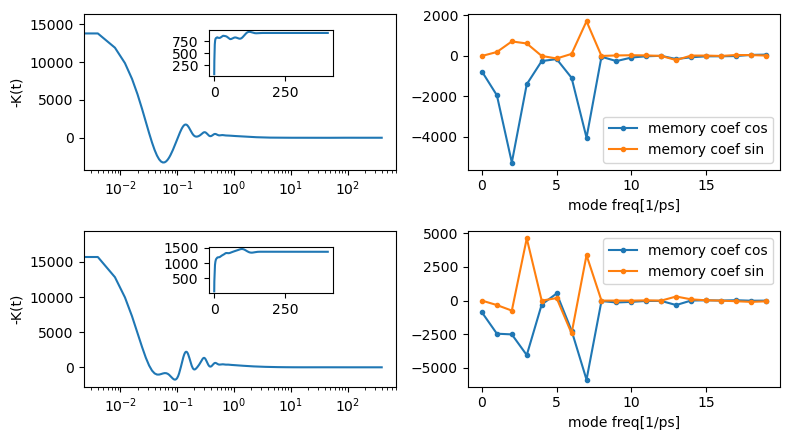

In [6]:
fig, ax = plt.subplots(2,2, figsize=(8,4.5))
tgrid = np2th(np.arange(2*nmax)) * dt
mem_kernel = trainer.model.compute_memory_kernel(tgrid)  ## (ndim, nmax)
ax[0,0].semilogx(th2np(tgrid), -th2np(mem_kernel)[0])
ax[0,0].set_ylabel('-K(t)')
axins = ax[0,0].inset_axes([0.4, 0.6, 0.4, 0.3])
axins.plot(th2np(tgrid), -dt*np.cumsum((th2np(mem_kernel)[0]))) 

ax[1,0].semilogx(th2np(tgrid), -th2np(mem_kernel)[1])
ax[1,0].set_ylabel('-K(t)')
axins = ax[1,0].inset_axes([0.4, 0.6, 0.4, 0.3])
axins.plot(th2np(tgrid), -dt*np.cumsum((th2np(mem_kernel)[1]))) 


ax[0,1].plot( th2np(aigle.mem_coef_cos[0]), label='memory coef cos', marker='o', markersize=3)
ax[0,1].plot( th2np(aigle.mem_coef_sin[0]), label='memory coef sin', marker='o', markersize=3)
ax[0,1].legend()
ax[0,1].set_xlabel('mode freq[1/ps]')

ax[1,1].plot( th2np(aigle.mem_coef_cos[1]), label='memory coef cos', marker='o', markersize=3)
ax[1,1].plot( th2np(aigle.mem_coef_sin[1]), label='memory coef sin', marker='o', markersize=3)
ax[1,1].legend()
ax[1,1].set_xlabel('mode freq[1/ps]')

plt.tight_layout()